Python 3.11.2에 연결됨

In [3]:
import requests
import json
import math
import time

HOST = "http://127.0.0.1:56123"

REGISTRATION_URL = f"{HOST}/api/v4/rest-auth/registration/"
LOGIN_URL = f"{HOST}/api/v4/rest-auth/login/"
LOGOUT_URL = f"{HOST}/api/v4/rest-auth/logout/"
UPLOAD_URL = f"{HOST}/api/v4/upload"
DIVIDE_URL = f"{HOST}/api/v4/parser/divide"
PARSE_URL = f"{HOST}/api/v4/parser/parse"
ANNOTATE_URL = f"{HOST}/api/v4/annotator/annotate"
CORPUSES_URL = f"{HOST}/api/v4/corpuses/"

url = "http://127.0.0.1:56123"


In [4]:
join_membership = {
    "username": "abc111",
    "email": "abcdefghi12@naver.com",
    "password1": "testaaaaaa!",
    "password2": "testaaaaaa!"
}

join_membership_response = requests.post(REGISTRATION_URL, data=join_membership)

login = {
    "username": "abc111",
    "email": "abcdefghi12@naver.com",
    "password": "testaaaaaa!"
}

login_response= requests.post(LOGIN_URL, json=login)
login_data = login_response.json()
token = login_data.get('key')

login_key = {
    'Authorization': f'Token {token}'
}


In [5]:
texts = [
    {
        "original_text": "Der Wind spielt mit der Wetterfahne und den Herzen, während der Flüchtling im Glauben, eine treue Frau zu finden, die falschen Zeichen liest und sich seiner eigenen Schmerzen und vergeblichen Suche nach Liebe bewusst wird."
    },
    {
        "original_text": "Gefrorne Tropfen fallen von meinen Wangen ab, und ich wundere mich, ob ich überhaupt geweint habe; meine Tränen sind so kalt wie der Frost, obwohl sie aus einer heißen, glühenden Quelle stammen, die den ganzen Winter schmelzen möchte."
    },
    {
        "original_text": "Ich suche vergebens im Schnee nach den Spuren ihrer Schritte, will den Boden küssen und durch Eis und Schnee mit meinen heißen Tränen dringen, um wieder Erde zu sehen; doch alles ist erstorben und blass, und wenn meine Schmerzen schweigen, bleibt mir nur die Frage, wer mir von ihr erzählt, während mein Herz wie erfroren in ihrem Bild erstarrt."
    },
    {
        "original_text": "Am Brunnen vor dem Tor steht ein Lindenbaum, unter dessen Schatten ich viele süße Träume hatte; ich schnitt liebe Worte in seine Rinde und wurde von ihm stets in Freud’ und Leid angezogen. Heute Nacht, als ich an ihm vorbeiging, hörte ich seine Zweige rauschen und rufen, ich möge zu ihm kommen und Ruhe finden, doch ich wandte mich nicht, obwohl der Wind mir ins Gesicht blies. Nun, weit entfernt, höre ich immer noch das Rauschen, das mir Ruhe verspricht."

    },
    {
        "original_text": "Hier und da sieht man an den Bäumen noch ein buntes Blatt, und ich bleibe oft in Gedanken stehen, schaue auf das einzelne Blatt und hänge meine Hoffnung daran; wenn der Wind mit dem Blatt spielt, zittere ich vor Angst, und wenn das Blatt zu Boden fällt, fällt meine Hoffnung mit ihm, und ich selbst werde am Boden weinend über das Grab meiner Hoffnung fallen."

    },
    {
        "original_text": "Warum vermeide ich die Wege, die andere Wanderer gehen, und suche versteckte Stege durch verschneite Felsen? Ich habe doch nichts begangen, das mich dazu zwingt, Menschen zu meiden. Welches törichte Verlangen treibt mich in die Einöde? Die Weisen zeigen den Weg zu den Städten, doch ich wandere maßlos und suche vergeblich Ruhe, indem ich einen Weg gehe, den noch niemand zurückgegangen ist."
    }
]

In [ ]:
time_list = []
annotate_list = []
annotators = ["chatgpt_ft0", "chatgpt_gpt-3.5-turbo-untrained_0","chatgpt_gpt-3.5-turbo-pretrained_0","chatgpt_gpt-4o-mini-untrained_0","chatgpt_gpt-4o-mini-pretrained_0"]

for annotator_name in annotators:
    for text in texts:
        upload_response = requests.post(UPLOAD_URL, json=text, headers=login_key)
        corpus_id = upload_response.json().get('corpus_id')

        divide_data = {
            "corpus_id": corpus_id,
            "divide_options": json.dumps({"p_delims": ["\n"]})
        }
        divide_response = requests.post(DIVIDE_URL, json=divide_data, headers=login_key)

        parse_data = {
            "corpus_id": corpus_id,
            "parse_options": json.dumps({"t_delims": " \t\n\r\u000b\f"})
        }
        parse_response = requests.post(PARSE_URL, json=parse_data, headers=login_key)

        start = time.time()

        annotate_data = {
            "corpus_id": corpus_id,
            "annotate_options": json.dumps({
                "lang_from": "German",
                "lang_to": "English",
                "annotator_name": annotator_name
            })
        }
        annotate_response = requests.post(ANNOTATE_URL, json=annotate_data, headers=login_key)
        
        end = time.time()
        print(annotator_name)
        print(f"{end - start:.5f} sec")
        time_list.append(end - start)
        annotate_list.append(annotator_name)


In [ ]:
corpuses_respons = requests.get(CORPUSES_URL, headers=login_key)
corpuse_history = corpuses_respons.json()
rate_list = []
texts_len = len(texts) # 6
num = int(corpuse_history[-1].get('corpus_id'))  # 마지막 코퍼스의 ID 가져오기
first = num - (texts_len*len(annotators))
number2 = 0

for number in range(first, num):
    Unknown_count = 0
    token_sum = 0
    for corpus_record in corpuse_history[number]['corpuses_history']:
        for paragraph in corpus_record['paragraphs']:
            if paragraph['pstate'] == "ANNOTATED":
                for token in paragraph.get('tokens', []):
                    if not token['is_delimiter']:
                        token_sum += 1
                        if token.get('gloss') == "!UNKNOWN" or token.get('gloss') is None:
                            Unknown_count += 1
                            print(token)

    if token_sum > 0:
        Return_rate = ((token_sum - Unknown_count) / token_sum) * 100
        rate_list.append(Return_rate)
        print(number2, "annotator_name:", annotate_list[number2], "time:", round(float(time_list[number2]), 2), ", return_rate:", round(Return_rate, 2))
        
    else:
        print(number, "time:", round(float(time_list[number2]), 2), ", No tokens to calculate return rate")
        
    number2 += 1


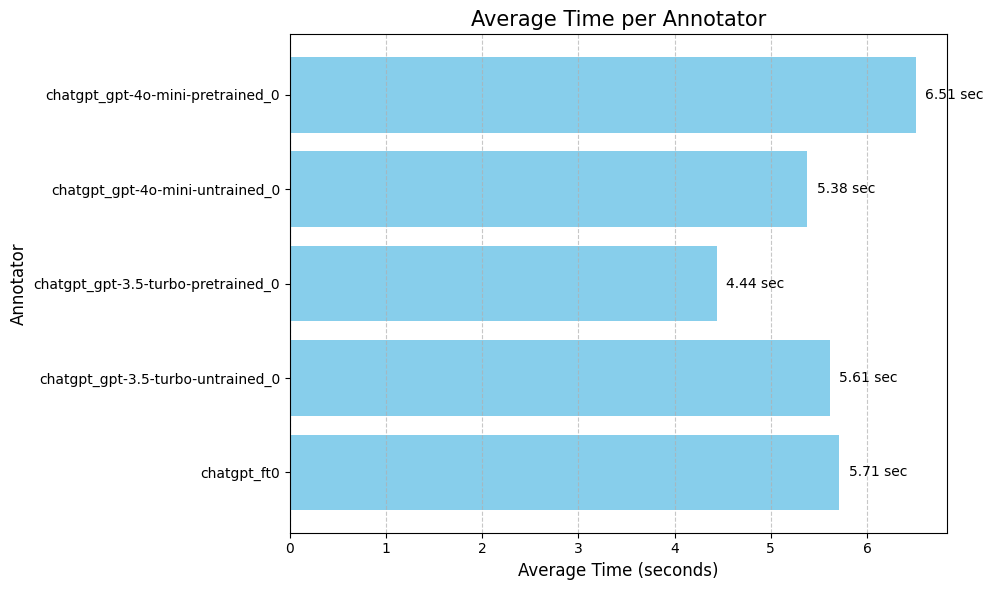

In [9]:
import matplotlib.pyplot as plt
import numpy as np

annotator_dict = {}
for annotator, time in zip(annotate_list, time_list):
    if annotator in annotator_dict:
        annotator_dict[annotator].append(time)
    else:
        annotator_dict[annotator] = [time]


annotator_avg = {k: np.mean(v) for k, v in annotator_dict.items()}

names = list(annotator_avg.keys())
avg_times = list(annotator_avg.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(names, avg_times, color='skyblue')

# 각 막대 옆에 값 표시
for bar, avg_time in zip(bars, avg_times):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{avg_time:.2f} sec', va='center')

plt.xlabel('Average Time (seconds)', fontsize=12)
plt.ylabel('Annotator', fontsize=12)
plt.title('Average Time per Annotator', fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # X축에 점선 그리드 추가

plt.tight_layout()  
plt.show()

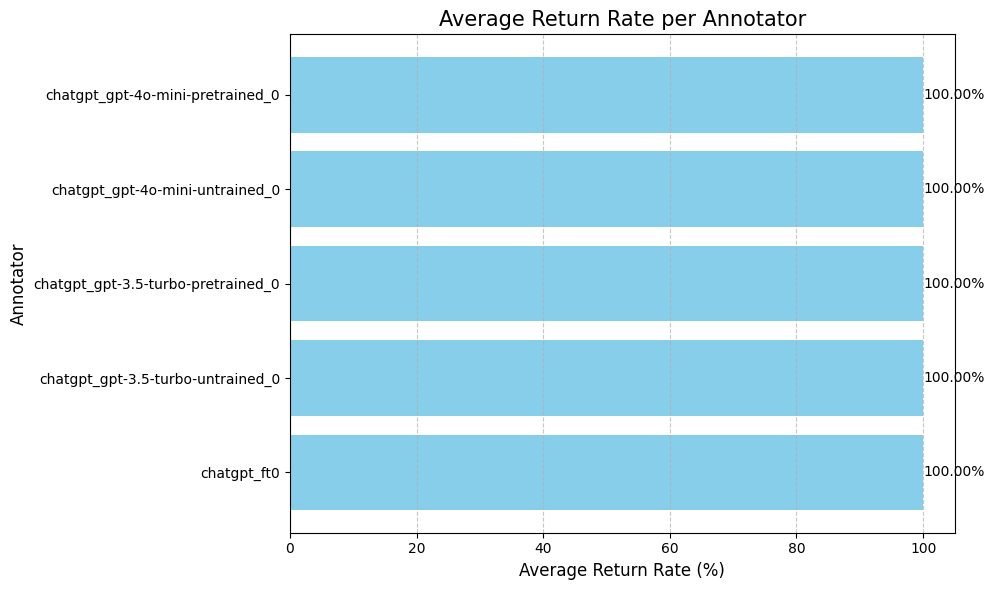

In [10]:
annotator_dict = {}
for annotator, rate in zip(annotate_list, rate_list):
    if annotator in annotator_dict:
        annotator_dict[annotator].append(rate)
    else:
        annotator_dict[annotator] = [rate]

annotator_avg = {k: np.mean(v) for k, v in annotator_dict.items()}

names = list(annotator_avg.keys())
avg_rates = list(annotator_avg.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(names, avg_rates, color='skyblue')

# 각 막대 옆에 평균 Return Rate 값 표시
for bar, avg_rate in zip(bars, avg_rates):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{avg_rate:.2f}%', va='center')

plt.xlabel('Average Return Rate (%)', fontsize=12)
plt.ylabel('Annotator', fontsize=12)
plt.title('Average Return Rate per Annotator', fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # X축에 점선 그리드 추가

plt.tight_layout()  
plt.show()